# We're going to load WOfS data of Tantangara dam only for the days when the dam was really full

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser

#We have to add the plotting tools to the directory list with path.append
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

%load_ext autoreload

%autoreload 2

# Load water level data as an xarray

In [2]:
gauge_data = pd.read_csv('/g/data/r78/kd6095/dea-notebooks/Tantangara/Tantangara_water_level.csv',
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))

gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100

gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')

gauge_data_xr = gauge_data.to_xarray()

# Dask load WOfS data

In [3]:
lat, lon, buffer = -35.75, 148.66, 6500
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2000-01-01', '2019-01-01'), 
         'crs': 'EPSG:3577'} 

dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)
wofs_albers

<xarray.Dataset>
Dimensions:  (time: 1179, x: 521, y: 521)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T23:43:29.500000 ... 2018-12-28T23:50:34
  * y        (y) float64 -3.997e+06 -3.997e+06 ... -4.01e+06 -4.01e+06
  * x        (x) float64 1.495e+06 1.495e+06 1.495e+06 ... 1.508e+06 1.508e+06
Data variables:
    water    (time, y, x) int16 dask.array<shape=(1179, 521, 521), chunksize=(1, 521, 521)>
Attributes:
    crs:      EPSG:3577

# Merge data

In [4]:
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)
merged_data

<xarray.Dataset>
Dimensions:     (time: 1179)
Coordinates:
    Timestamp   (time) datetime64[ns] 2000-01-01T23:43:29.500000 ... 2018-12-28T23:50:34
  * time        (time) datetime64[ns] 2000-01-01T23:43:29.500000 ... 2018-12-28T23:50:34
Data variables:
    Value       (time) float64 1.209e+03 1.209e+03 ... 1.221e+03 1.221e+03
    rownumber   (time) float64 3.276e+03 3.013e+03 ... 7.258e+03 7.23e+03
    Exceedence  (time) float64 56.25 59.77 63.18 72.42 ... 3.712 3.084 3.456

# Specify which satellite passes to load (for real this time) based on water level

First, have a quick look at the duration curve to decide which level you want to look at. I'm going to choose above 1220

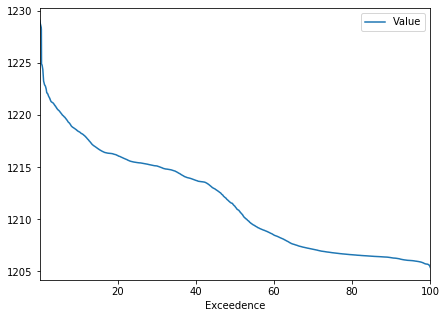

In [5]:
gauge_data.plot(x='Exceedence', y='Value', figsize=(7, 5))

In [6]:
specified_level = merged_data.where((merged_data.Value >1220) & (merged_data.Value < 1230), drop=True)
specified_level

<xarray.Dataset>
Dimensions:     (time: 73)
Coordinates:
    Timestamp   (time) datetime64[ns] 2010-12-13T23:46:42.500000 ... 2018-12-28T23:50:34
  * time        (time) datetime64[ns] 2010-12-13T23:46:42.500000 ... 2018-12-28T23:50:34
Data variables:
    Value       (time) float64 1.22e+03 1.22e+03 ... 1.221e+03 1.221e+03
    rownumber   (time) float64 7.114e+03 7.123e+03 ... 7.258e+03 7.23e+03
    Exceedence  (time) float64 5.008 4.889 4.58 4.659 ... 3.712 3.084 3.456

Here's a list of all the time points you have satellite passes for at the specified level.

In [7]:
date_list = specified_level.time.values
#date_list

# Load the wofs data day by day with a for-loop

NOTE: You must take the time category out of the query! We don't want to load a range of dates, we want to load our list of dates

In [8]:
lat, lon, buffer = -35.75, 148.66, 6500
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer), 
         'crs': 'EPSG:3577'} 

OK, now we have to make a for-loop to load each pass individually:  
for each date in this list of dates
load data from the datacube,
append the loaded data to a list of xarrays

In [13]:
xr_list = []

for date in date_list:
    #print(date)
    date = str(date)  
    wofs_albers= dc.load(product = 'wofs_albers', time=date,  **query)
    xr_list.append(wofs_albers)

# Concatenate the passes into one dataset 

In [14]:
specified_passes = xr.concat(xr_list, dim='time')
specified_passes

<xarray.Dataset>
Dimensions:  (time: 73, x: 521, y: 521)
Coordinates:
  * y        (y) float64 -3.997e+06 -3.997e+06 ... -4.01e+06 -4.01e+06
  * x        (x) float64 1.495e+06 1.495e+06 1.495e+06 ... 1.508e+06 1.508e+06
  * time     (time) datetime64[ns] 2010-12-13T23:46:42.500000 ... 2018-12-28T23:50:34
Data variables:
    water    (time, y, x) int16 32 32 32 32 32 32 32 32 ... 80 80 80 80 80 80 80
Attributes:
    crs:      EPSG:3577

# Cloud mask

In [15]:
ClearTimesteps = []
for ix, timestep in enumerate(specified_passes.time):
    SingleTime = specified_passes.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()
    
#Here's the part that measures the percentage of bit flags that mean cloud in the satellite image
    PercentCloudy = CountClouds.values.item()/(len(specified_passes.x)*len(specified_passes*y))*100
#And here's the part where we select how much cloud we're willing to accept in our satellite images. try 20. 
    IsItClearEnough = PercentCloudy <= 20
    
#Then we say 'if IsItClearEnough = True, then append it to an index called ClearTimesteps'.
    if IsItClearEnough:
        ClearTimesteps.append(ix)
        
        
clear_specified_passes = specified_passes.water.isel(time = ClearTimesteps)
clear_specified_passes.time

<xarray.DataArray 'time' (time: 11)>
array(['2010-12-21T23:49:56.000000000', '2010-12-22T23:40:34.500000000',
       '2010-12-29T23:46:46.500000000', '2016-10-26T23:57:13.000000000',
       '2016-11-03T23:59:30.500000000', '2016-11-19T23:59:24.000000000',
       '2016-11-20T23:51:02.000000000', '2016-11-27T23:57:12.500000000',
       '2016-12-06T23:51:00.000000000', '2018-09-22T23:54:36.500000000',
       '2018-12-03T23:56:46.500000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-12-21T23:49:56 ... 2018-12-03T23:56:46.500000
Attributes:
    units:    seconds since 1970-01-01 00:00:00

# Now plot the specified passes as one WOfS summary image

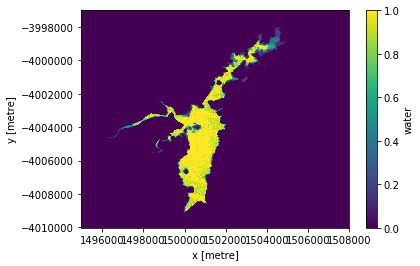

In [59]:
wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows

frequency.plot()

Nice, now you have a picture of what the dam looks like when the water level is above 1220m (that's m above sea level btw). 